In [2]:
import config
from RiotAPI import *
from RiotRequest import RiotRequest
import requests

In [3]:
# timestamp handling functions
from datetime import timedelta
from datetime import datetime
import pytz

def convert_timedelta(milisecs):
    '''
    convert milisecond timestamp into python timedelta object
    for sake of compatiability, convert into only minutes and seconds (without hours)
    '''
    minDelta = timestamp // 60000 # 60000 miliseconds == 1 minute
    secDelta = (timestamp % 60000) // 1000 # 1000 miliseconds == 1 second
    return timedelta(minutes = minDelta, seconds = secDelta)

def convert_timestamp(timestamp):
    '''convert unix timestamp(long) into python datetime object with Korean Timezone'''
   
    # dealing with miliseconds part
    timestamp = timestamp/1000
    # convert from utc into datetime timestamp
    dt = datetime.utcfromtimestamp(timestamp).replace(tzinfo=pytz.utc)
    
    # convert into Korean timezone
    tz = pytz.timezone("Asia/Seoul")
    dt_kr = dt.astimezone(tz)
    
    return dt_kr

In [4]:
api_key = config.api_key
game_id = 3309773060
summoner_name = "야너어어어엌"
account_id = get_account_id(summoner_name)

## Match Time History

In [5]:
history = [match['gameId'] for match in get_match_history(account_id)]

In [6]:
len(history)

568

In [7]:
# get game detail에서 gameCreation이랑 gameDuration만 불러오기

# 이러면 get_game_detail을 두 번 호출함ㅜㅜ --> 너무 오래걸림
# history = [[matchId, get_game_detail(matchId)['gameCreation'], get_game_detail(matchId)['gameDuration']] for matchId in history]

def get_timeinfo(matchId):
    detail = get_game_detail(matchId)
    return [matchId, detail['gameCreation'], detail['gameDuration']]

# temporarily recent 300 games
time_history = [get_timeinfo(matchId) for matchId in history[:300]]


Exceeded Rate Limiting. Will retry After 79 seconds
Exceeded Rate Limiting. Will retry After 77 seconds
Exceeded Rate Limiting. Will retry After 79 seconds


In [8]:
import pandas as pd
match_df = pd.DataFrame(time_history, columns=['matchId', 'creation', 'duration'])

In [9]:
# add unix timestamp of the time game ended
match_df['ended'] = match_df['creation'] + match_df['duration']*1000

# add datetime columns for creation and ending time
match_df['creation_dt'] = match_df['creation'].apply(convert_timestamp)
match_df['ended_dt'] = match_df['ended'].apply(convert_timestamp)

match_df.head()

,matchId,creation,duration,ended,creation_dt,ended_dt
0,3663346965,1557981210348,1285,1557982495348,2019-05-16 13:33:30.348000+09:00,2019-05-16 13:54:55.348000+09:00
1,3663315079,1557979516493,1501,1557981017493,2019-05-16 13:05:16.493000+09:00,2019-05-16 13:30:17.493000+09:00
2,3662344066,1557912999893,1220,1557914219893,2019-05-15 18:36:39.893000+09:00,2019-05-15 18:56:59.893000+09:00
3,3659959097,1557747014172,1783,1557748797172,2019-05-13 20:30:14.172000+09:00,2019-05-13 20:59:57.172000+09:00
4,3658808527,1557660795816,1698,1557662493816,2019-05-12 20:33:15.816000+09:00,2019-05-12 21:01:33.816000+09:00


## Grouping Matches
__match_df: 개별 게임 기록을 하나의 row로 하는 dataframe__
- matchId(index)
- creation: __long__ 게임이 시작하는 unix timestamp
- duration: __int__ 게임 지속 시간 in seconds (*millisedconds가 아님에 유의*)
- ended: __long__ 게임이 끝나는 unix timestamp
- creation_dt: __datetime__ creation을 korean time으로 전환한 시각   
- ended_dt: __datetime__ ended를 korean time으로 전환한 시각  
- diff: __long__ 이번 판과 다음 판(시간 상으로 다음판, row 순서로는 바로 위 row)과의 시간 차이 in seconds

__seq_df: 연속 게임 기록을 하나의 row로 하는 dataframe__
- matchIds: list[matchId]
- matchNum: __int__ 연속으로 한 판 수
- start_dt: __datetime__ 연속 게임 기록의 시작시간
- end_dt: __datetime__ 연속 게임 기록의 끝나는 시간

In [11]:
import numpy as np
diff = np.array(match_df['creation'][:-1]) - np.array(match_df['ended'][1:])
len(diff)

299

In [12]:
import matplotlib
import matplotlib.pyplot as plt
plt = plt.hist(diff)

In [13]:
full_diff = np.append([float('Inf')], diff)
full_diff
match_df['diff'] = full_diff
match_df.head()

,matchId,creation,duration,ended,creation_dt,ended_dt,diff
0,3663346965,1557981210348,1285,1557982495348,2019-05-16 13:33:30.348000+09:00,2019-05-16 13:54:55.348000+09:00,inf
1,3663315079,1557979516493,1501,1557981017493,2019-05-16 13:05:16.493000+09:00,2019-05-16 13:30:17.493000+09:00,1.928550e+05
2,3662344066,1557912999893,1220,1557914219893,2019-05-15 18:36:39.893000+09:00,2019-05-15 18:56:59.893000+09:00,6.529660e+07
3,3659959097,1557747014172,1783,1557748797172,2019-05-13 20:30:14.172000+09:00,2019-05-13 20:59:57.172000+09:00,1.642027e+08
4,3658808527,1557660795816,1698,1557662493816,2019-05-12 20:33:15.816000+09:00,2019-05-12 21:01:33.816000+09:00,8.452036e+07


In [29]:
match_df.set_index('matchId', inplace=True)
match_df.head()

,creation,duration,ended,creation_dt,ended_dt,diff
matchId,,,,,,
3663346965,1557981210348,1285,1557982495348,2019-05-16 13:33:30.348000+09:00,2019-05-16 13:54:55.348000+09:00,inf
3663315079,1557979516493,1501,1557981017493,2019-05-16 13:05:16.493000+09:00,2019-05-16 13:30:17.493000+09:00,1.928550e+05
3662344066,1557912999893,1220,1557914219893,2019-05-15 18:36:39.893000+09:00,2019-05-15 18:56:59.893000+09:00,6.529660e+07
3659959097,1557747014172,1783,1557748797172,2019-05-13 20:30:14.172000+09:00,2019-05-13 20:59:57.172000+09:00,1.642027e+08
3658808527,1557660795816,1698,1557662493816,2019-05-12 20:33:15.816000+09:00,2019-05-12 21:01:33.816000+09:00,8.452036e+07


In [33]:
# contruct sequence data
seqs = []

for index, row in match_df.iterrows():
    if row['diff'] > 600000: # diff with previous game bigger than 10 minutes
        seqs.append([index]) # start a new sequence(nested list) in seqs
    else: # diff with previous game smaller than 10 minutes
        seqs[-1].append(index) # add the match to an existing sequence

In [36]:
seq_df = pd.DataFrame()

# list of ids of matches
seq_df['matchIds'] = seqs
# how many matches in a row
seq_df['matchNum'] = [len(seq) for seq in seqs]
# start_dt
seq_df['start_dt'] = [match_df.loc[seq[-1]]['creation_dt'] for seq in seqs]
# end_dt
seq_df['end_dt'] = [match_df.loc[seq[0]]['ended_dt'] for seq in seqs]

seq_df.head()

,matchIds,matchNum,start_dt,end_dt
0,"[3663346965, 3663315079]",2,2019-05-16 13:05:16.493000+09:00,2019-05-16 13:54:55.348000+09:00
1,[3662344066],1,2019-05-15 18:36:39.893000+09:00,2019-05-15 18:56:59.893000+09:00
2,[3659959097],1,2019-05-13 20:30:14.172000+09:00,2019-05-13 20:59:57.172000+09:00
3,"[3658808527, 3658851282, 3658735829, 3658669989]",4,2019-05-12 19:00:04.238000+09:00,2019-05-12 21:01:33.816000+09:00
4,[3655968230],1,2019-05-11 11:06:56.795000+09:00,2019-05-11 11:41:00.795000+09:00


## 데이터 저장하기
sqlite에서는 datetime object가 저장이 안돼서 pickle로

In [64]:
# import sqlite3 

# con = sqlite3.connect("GameSequence.db")
# match_df.to_sql("match", con, chunksize=1000, if_exists='replace')
# seq_df.to_sql("sequence", con, chunksize=1000, if_exists='replace')
# con.commit()
# con.close()

TypeError: Cannot cast DatetimeIndex to dtype datetime64[us]

In [73]:
import pickle

match_df.to_pickle("match.pickle")
seq_df.to_pickle("sequence.pickle")

with open('match.pickle', 'rb') as f:
    data = pickle.load(f)
data.head()

,creation,duration,ended,creation_dt,ended_dt,diff,win
matchId,,,,,,,
3663346965,1557981210348,1285,1557982495348,2019-05-16 13:33:30.348000+09:00,2019-05-16 13:54:55.348000+09:00,inf,True
3663315079,1557979516493,1501,1557981017493,2019-05-16 13:05:16.493000+09:00,2019-05-16 13:30:17.493000+09:00,1.928550e+05,False
3662344066,1557912999893,1220,1557914219893,2019-05-15 18:36:39.893000+09:00,2019-05-15 18:56:59.893000+09:00,6.529660e+07,True
3659959097,1557747014172,1783,1557748797172,2019-05-13 20:30:14.172000+09:00,2019-05-13 20:59:57.172000+09:00,1.642027e+08,False
3658808527,1557660795816,1698,1557662493816,2019-05-12 20:33:15.816000+09:00,2019-05-12 21:01:33.816000+09:00,8.452036e+07,False


## 승률 데이터 접목하기

In [56]:
# 흠 너무 느린데
def win_match(accountId, matchId):
    '''accountId가 matchId에서 이겼으면 True, 졌으면 False를 반환.내부에서 get_game_detail 리퀘스트를 보낸다 '''
    
    detail = get_game_detail(matchId)
    
    # get the participant Id of the user in the specific match
    for p in detail['participantIdentities']:
        if p['player']['accountId'] == accountId:
            participantId = p['participantId']
            break
            
    # team 100의 결과('Fail' or 'Win')
    team100 = detail['teams'][0]['win'] 
    
    # participant belongs to team 100
    if participantId <= 5:    
        return team100 == 'Win' 
    
    # participant belongs to team 200
    else:            
        return team100 == 'Fail'

In [70]:
match_df['win'] = [win_match(account_id, i) for i in match_df.index.values]

Exceeded Rate Limiting. Will retry After 80 seconds
Exceeded Rate Limiting. Will retry After 79 seconds


In [71]:
match_df.head()

,creation,duration,ended,creation_dt,ended_dt,diff,win
matchId,,,,,,,
3663346965,1557981210348,1285,1557982495348,2019-05-16 13:33:30.348000+09:00,2019-05-16 13:54:55.348000+09:00,inf,True
3663315079,1557979516493,1501,1557981017493,2019-05-16 13:05:16.493000+09:00,2019-05-16 13:30:17.493000+09:00,1.928550e+05,False
3662344066,1557912999893,1220,1557914219893,2019-05-15 18:36:39.893000+09:00,2019-05-15 18:56:59.893000+09:00,6.529660e+07,True
3659959097,1557747014172,1783,1557748797172,2019-05-13 20:30:14.172000+09:00,2019-05-13 20:59:57.172000+09:00,1.642027e+08,False
3658808527,1557660795816,1698,1557662493816,2019-05-12 20:33:15.816000+09:00,2019-05-12 21:01:33.816000+09:00,8.452036e+07,False


### 참고: Dataframe의 Chained Assignment 
https://www.dataquest.io/blog/settingwithcopywarning/  
문제 - 계속 SettingWithCopyWarning 나옴. bracket을 두 개 이상 사용해서(chaining) 접근한 subset of data는 original data가 아니라 copy 된 것. 여기에 할당을 해봤자 원데이터는 바뀌지 않는다
해결책 - loc에 합친다  
Chaining Assignment: `data[data.bidder == 'parakeet2004']['bidderrate'] = 100`   
=> .loc을 활용한 single operation: `data.loc[data.bidder == 'parakeet2004', 'bidderrate'] = 100` 

In [123]:
# 몇 번째 판인지
match_df['seq_idx'] = np.nan
for seq in seq_df['matchIds']:
    for idx, match in enumerate(seq):
        match_df.loc[match, 'seq_idx'] = idx

In [124]:
match_df.head()

,creation,duration,ended,creation_dt,ended_dt,diff,win,weekday,hour,seq_idx
matchId,,,,,,,,,,
3663346965,1557981210348,1285,1557982495348,2019-05-16 13:33:30.348000+09:00,2019-05-16 13:54:55.348000+09:00,inf,True,3,13,0.0
3663315079,1557979516493,1501,1557981017493,2019-05-16 13:05:16.493000+09:00,2019-05-16 13:30:17.493000+09:00,1.928550e+05,False,3,13,1.0
3662344066,1557912999893,1220,1557914219893,2019-05-15 18:36:39.893000+09:00,2019-05-15 18:56:59.893000+09:00,6.529660e+07,True,2,18,0.0
3659959097,1557747014172,1783,1557748797172,2019-05-13 20:30:14.172000+09:00,2019-05-13 20:59:57.172000+09:00,1.642027e+08,False,0,20,0.0
3658808527,1557660795816,1698,1557662493816,2019-05-12 20:33:15.816000+09:00,2019-05-12 21:01:33.816000+09:00,8.452036e+07,False,6,20,0.0


In [150]:
grouped = match_df[['win', 'seq_idx']].groupby('seq_idx')
grouped_win = (grouped.sum()/grouped.count())['win'].values
grouped.index

AttributeError: Cannot access attribute 'index' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [146]:
list(range(0,len(grouped)))

[0, 1, 2, 3, 4, 5]

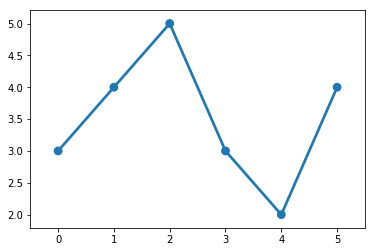

In [144]:
sns.pointplot(x=list(range(0,len(grouped))), y=grouped_win)
sns.pointplot(x=[0,1,2,3,4,5], y=[3, 4, 5, 3,2,4])

## Insights on Play Time

### 한 번에 켰을 때 몇 판이나 연속으로 했을까  
seaborn countplot

In [79]:
matchNum = seq_df['matchNum'].value_counts()
matchNum

2    61
1    53
3    21
4     6
5     4
6     3
Name: matchNum, dtype: int64

Text(0,0.5,'Count')

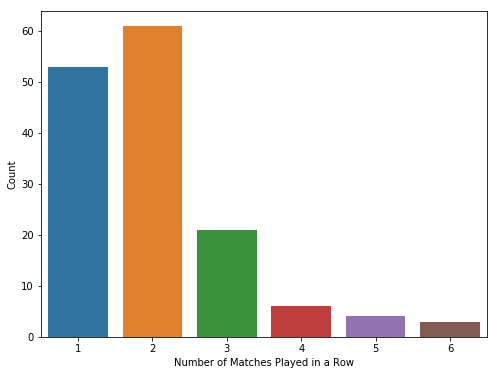

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.countplot(x='matchNum', data=seq_df)
plt.xlabel('Number of Matches Played in a Row')
plt.ylabel('Count')

### 무슨 요일, 어떤 시간대에 게임을 할까  
seaborn heatmap: https://seaborn.pydata.org/generated/seaborn.heatmap.html

In [103]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
match_df['weekday'] = [dt.weekday() for dt in match_df['creation_dt']]
match_df['hour'] = [dt.hour for dt in match_df['creation_dt']]
matchTime = match_df.groupby('weekday')['hour'].value_counts().unstack().fillna(0)
matchTime

hour,0,1,2,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,2.0,3.0,5.0,2.0,1.0,2.0,0.0,8.0,7.0,4.0,8.0,8.0,2.0,3.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,9.0,6.0,3.0,1.0,2.0,2.0,4.0,3.0,2.0,0.0
2,3.0,2.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,1.0,3.0,4.0,1.0,4.0,1.0,3.0,2.0,1.0,1.0
3,1.0,0.0,0.0,0.0,1.0,2.0,4.0,3.0,14.0,6.0,3.0,3.0,2.0,1.0,3.0,2.0,3.0,3.0,6.0
4,0.0,0.0,2.0,3.0,1.0,1.0,3.0,2.0,1.0,3.0,3.0,3.0,3.0,1.0,3.0,5.0,4.0,1.0,2.0
5,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,6.0,3.0,3.0,5.0,0.0,3.0,2.0
6,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,3.0,5.0,3.0,5.0,2.0,1.0,6.0,6.0,4.0,4.0,0.0


In [104]:
sum(matchTime) # 왜 251개 밖에 안나오냐 어이없네

251

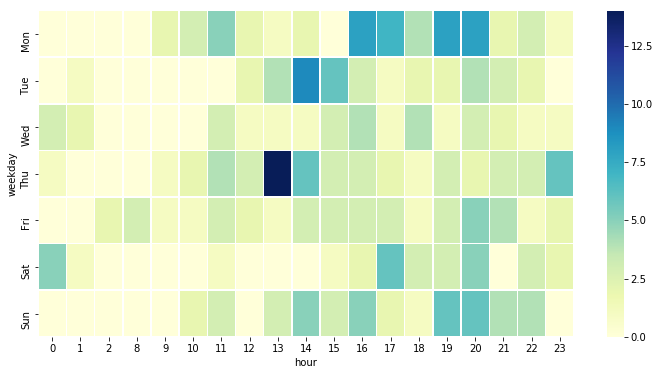

In [109]:
# 접속 시간대 분포 --> 게임이 30분~한 시간이니까 한 시간 단위로 끊으면 안될것같아
plt.figure(figsize=(12,6))
ax = sns.heatmap(matchTime, linewidths=.5, cmap="YlGnBu", yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

In [ ]:
# 간단히 한 판 하는 시간대 vs 여러 판 하는 시간대